In [2]:
import gym
import numpy as np
import matplotlib
import sys
from collections import defaultdict

%matplotlib inline

if "../" not in sys.path:
    sys.path.append("../") 
from lib.envs.blackjack import BlackjackEnv
from lib import plotting

matplotlib.style.use('ggplot')

In [3]:
env = BlackjackEnv()

In [4]:
def create_random_policy(nA):
    """
    Creates a random policy function.
    
    Args:
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes an observation as input and returns a vector
        of action probabilities
    """
    A = np.ones(nA, dtype=float) / nA
    def policy_fn(observation):
        return A
    return policy_fn

In [5]:
def create_greedy_policy(Q, epsilon):
    """
    Creates a greedy policy based on Q values.
    
    Args:
        Q: A dictionary that maps from state -> action values
        
    Returns:
        A function that takes an observation as input and returns a vector
        of action probabilities.
    """
    def policy_fn(observation):
        
        action_values = Q[observation]
        best_action = np.argmax(action_values)
        return np.eye(len(action_values))[best_action]
        
    return policy_fn

In [1]:
def mc_control_importance_sampling(env, num_episodes, behaviour_policy, discount_factor=1.0):
    """
    Monte Carlo Control Off-Policy Control using Weighted Importance Sampling.
    Finds an optimal greedy policy.
    
    Args:
        env: OpenAI gym environment.
        num_episodes: Number of episodes to sample.
        behavior_policy: The behavior to follow while generating episodes.
            A function that given an observation returns a vector of probabilities for each action.
        discount_factor: Gamma discount factor.
    
    Returns:
        A tuple (Q, policy).
        Q is a dictionary mapping state -> action values.
        policy is a function that takes an observation as an argument and returns
        action probabilities. This is the optimal greedy policy.
    """
    
    # Number of actions
    nA = env.action_space.n
    
    # Action Value function to be returned
    Q = defaultdict(lambda: np.zeros(nA))
    
    # The optimal policy to be returned
    policy = create_greedy_policy(Q)
    
    # store the number of times each state is visited 
    returns_num = defaultdict(float) 
        
    for episode in range(1, num_episodes + 1):
        
        if(episode % 100000 == 0):
            print('Running episode #{}...'.format(episode))
        
        # store the eligibility trace corresponding to each state-action pair for each episode
        eligibility_traces = defaultdict(float)
        
        # store the reward corresponding to each state-action for each episode
        episode_rewards = defaultdict(float)
                
        terminated = False
        state = env.reset()
        
        # termination condition
        while not terminated:
            
            # sample the action from the epsilon greedy policy
            action = np.random.choice(nA, p=behaviour_policy(state))
            
            # target is the greedy policy
            greedy_action = np.argmax(policy(state))
            
            # exit if the target action doesn't match the action chosen by the behaviour policy
            if(action != greedy_action):
                break
            
            # update the eligibility trace for the state-action pairs already visited in the episode 
            for (_state, _action) in eligibility_traces:
                
                eligibility_traces[(_state, _action)] *= discount_factor
            
            # add a new state-action pair to the dictionary if it's not been visited before
            if (state, action) not in eligibility_traces:
                
                eligibility_traces[(state, action)] = 1.0
                returns_num[(state, action)] += 1
                
                
            # perform the action in the environment
            next_state, reward, terminated, _ = env.step(action)
            
            # update the reward for each state-action pair
            for (_state, _action) in eligibility_traces:
                
                # since the action of the action chosen for the current state is 1 for our target 
                # policy (since it is a greedy policy), we can simply divide by the 
                # action value corresponding to the behaviour policy 
                episode_rewards[(_state, _action)] += eligibility_traces[(_state, _action)] * reward / behaviour_policy(state)[action]
            
            # update the current state
            state = next_state
        
        # update the action value function using incremental mean method
        for (state, action) in episode_rewards:
            Q[state][action] += (episode_rewards[(state, action)] - Q[state][action]) / returns_num[(state, action)]
        
        # Policy Improvement
        policy = create_greedy_policy(Q)
            
    return Q, policy


In [18]:
random_policy = create_random_policy(env.action_space.n)
Q, policy = mc_control_importance_sampling(env, num_episodes=500000, behaviour_policy=random_policy)

Running episode #100000...
Running episode #200000...
Running episode #300000...
Running episode #400000...
Running episode #500000...


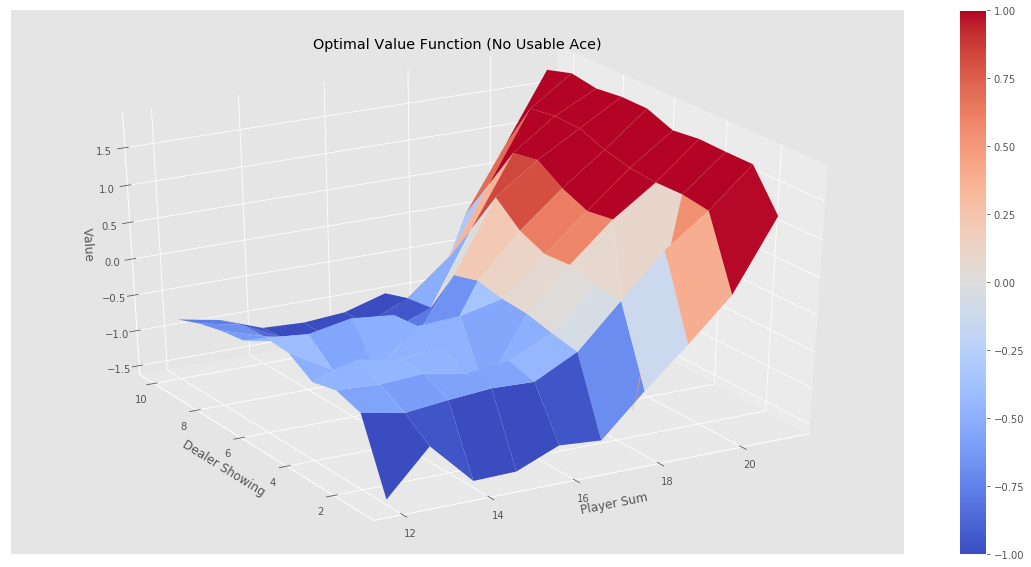

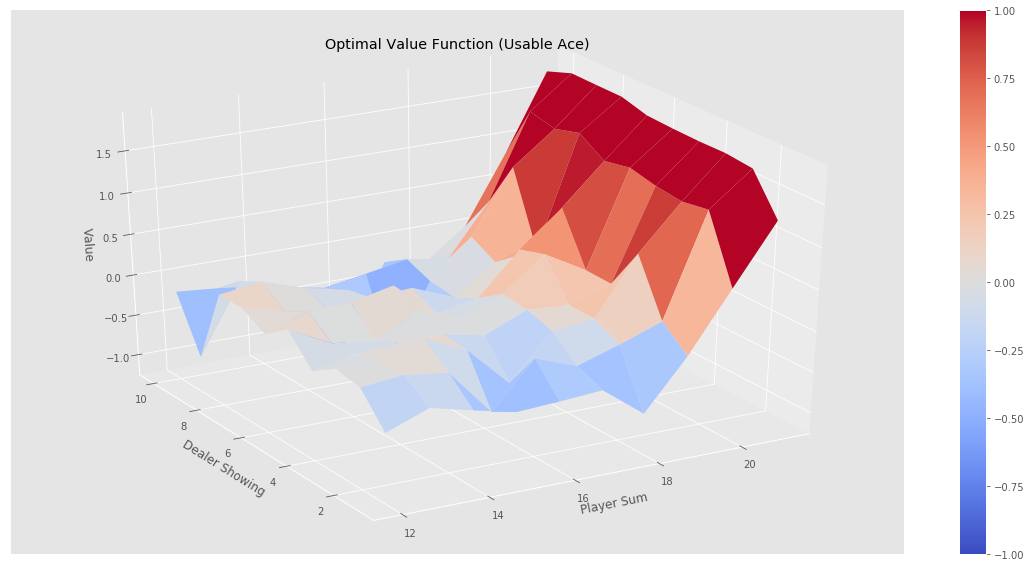

In [20]:
# For plotting: Create value function from action-value function
# by picking the best action at each state
V = defaultdict(float)
for state, action_values in Q.items():
    action_value = np.max(action_values)
    V[state] = action_value
plotting.plot_value_function(V, title="Optimal Value Function")